In [ ]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

Training for polynomial degree: 1
Epoch: 100/100| Avg loss: 0.20537
Training for polynomial degree: 2
Epoch: 100/100| Avg loss: 0.19955
Training for polynomial degree: 3
Epoch: 100/100| Avg loss: 0.14328
Training for polynomial degree: 4
Epoch: 100/100| Avg loss: 0.13131
Training for polynomial degree: 5
Epoch: 100/100| Avg loss: 0.12540
Training for polynomial degree: 6
Epoch: 100/100| Avg loss: 0.11945


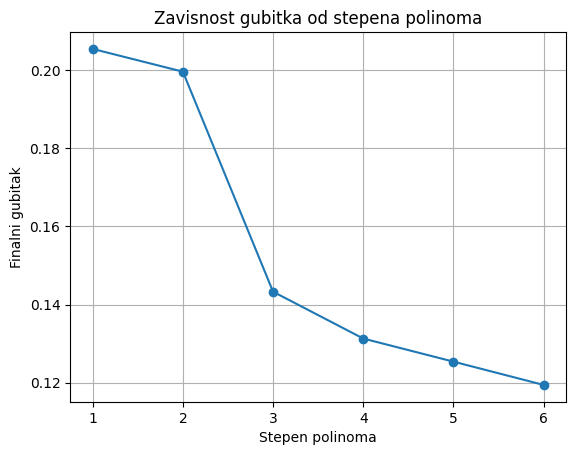

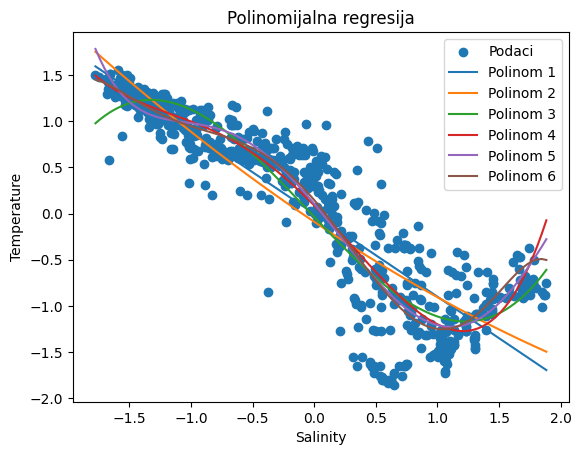

In [ ]:
# Pomocna funkcija koja od niza trening primera pravi feature matricu (m X n).
def create_feature_matrix(x, nb_features):
    tmp_features = []
    for deg in range(1, nb_features+1):
        tmp_features.append(np.power(x, deg))
    return np.column_stack(tmp_features)

# Učitavanje i obrada podataka.
filename = 'bottle.csv'
all_data = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(5, 6), max_rows=700, missing_values='', filling_values=np.nan)

# Redovi u kojima je bilo prazno polje su isključeni iz obrade podataka.
all_data = all_data[~np.isnan(all_data).any(axis=1)]
data = dict()
data['x'] = all_data[:, 0].astype(np.float32)
data['y'] = all_data[:, 1].astype(np.float32)

# Normalizacija
data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

# Nasumično mešanje.
nb_samples = data['x'].shape[0]
indices = np.random.permutation(nb_samples)
data['x'] = data['x'][indices]
data['y'] = data['y'][indices]

learning_rate = 0.001

# Funkcija troška i optimizacija.
def loss(x, y, w, b,deg):
    prediction = pred(x, w, b,deg)
    y_col = tf.reshape(y, (-1, 1))
    mse = tf.reduce_mean(tf.square(prediction - y_col))
    return mse

# Računanje gradijenta
def calc_grad(x, y, w, b,deg):
    with tf.GradientTape() as tape:
        loss_val = loss(x, y, w, b,deg)

    w_grad, b_grad = tape.gradient(loss_val, [w, b])

    return w_grad, b_grad, loss_val

# Prelazimo na AdamOptimizer jer se prost GradientDescent loše snalazi sa složenijim funkcijama.
adam = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)

# Trening korak
def train_step(x, y, w, b,deg):
    w_grad, b_grad, loss_val = calc_grad(x, y, w, b,deg)
    adam.apply_gradients(zip([w_grad, b_grad], [w, b]))
    return loss_val

# Funkcija za predikciju
def pred(x, w, b,deg):
    w_col = tf.reshape(w, (deg, 1))
    hyp = tf.add(tf.matmul(x, w_col), b)
    return hyp

# Definisanje broja epoha
nb_epochs = 100

# Definisanje intervala stepena polinoma
degrees = range(1, 7)

# Definisanje listi za čuvanje gubitaka i finalnih vrednosti parametara
final_losses = []
final_w_values = []
final_b_values = []

# Prolazak kroz svaki stepen polinoma
for degree in degrees:
    print(f"Training for polynomial degree: {degree}")

    # Kreiranje feature matrice za trenutni stepen polinoma
    nb_features = degree
    data['x_poly'] = create_feature_matrix(data['x'], nb_features)

    # Inicijalizacija težina i biasa
    w = tf.Variable(tf.zeros(nb_features))
    b = tf.Variable(0.0)

    # Trening modela
    for epoch in range(nb_epochs):
        # Stochastic Gradient Descent.
        epoch_loss = 0
        for sample in range(nb_samples):
            x = data['x_poly'][sample].reshape((1, nb_features))
            y = data['y'][sample]

            curr_loss = train_step(x, y, w, b,degree)
            epoch_loss += curr_loss

        # U svakoj stotoj epohi ispisujemo prosečan loss.
        epoch_loss /= nb_samples
        if (epoch + 1) % 100 == 0:
          print(f'Epoch: {epoch+1}/{nb_epochs}| Avg loss: {epoch_loss:.5f}')


    # Dodavanje finalnih vrednosti gubitaka i parametara
    final_losses.append(epoch_loss)
    final_w_values.append(w.numpy())
    final_b_values.append(b.numpy())
# Iscrtavanje grafika zavisnosti finalnog gubitka od stepena polinoma
plt.plot(degrees, final_losses, marker='o')
plt.title("Zavisnost gubitka od stepena polinoma")
plt.xlabel("Stepen polinoma")
plt.ylabel("Finalni gubitak")
plt.grid(True)
plt.show()

# Iscrtavanje grafika sa svim podacima i regresionim krivama
plt.scatter(data['x'], data['y'], label='Podaci')
for degree, w, b in zip(degrees, final_w_values, final_b_values):
    x_values = np.linspace(min(data['x']), max(data['x']), 100,dtype='float32')
    x_poly = create_feature_matrix(x_values, degree)
    w_col = tf.reshape(w,(degree,1))
    hyp = tf.add(tf.matmul(x_poly,w_col),b)
    #y_pred = pred(x_poly, w, b)
    plt.plot(x_values, hyp, label=f'Polinom {degree}')
plt.title("Polinomijalna regresija")
plt.xlabel("Salinity")
plt.ylabel("Temperature")
plt.legend()
plt.show()

